In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

In [2]:
def read_trigger_efficiencies(root_file_path):
    with uproot.open(root_file_path) as root_file:
        efficiency_tree = root_file["trigger_efficiencies_tree"]
        
        m_values = efficiency_tree["M"].array()
        n_values = efficiency_tree["N"].array()
        efficiencies = efficiency_tree["Efficiency"].array()
        efficiency_errors = efficiency_tree["EfficiencyError"].array()
        drift_distance = efficiency_tree["DriftDistance"].array()
        
        return m_values, n_values, efficiencies, efficiency_errors, drift_distance

In [3]:
root_file_path = "/home/lane/Software/src/lumilar/system/analysis/data/position_efficiencies.root"
m_values, n_values, efficiencies, efficiency_errors, drift_distance = read_trigger_efficiencies(root_file_path)

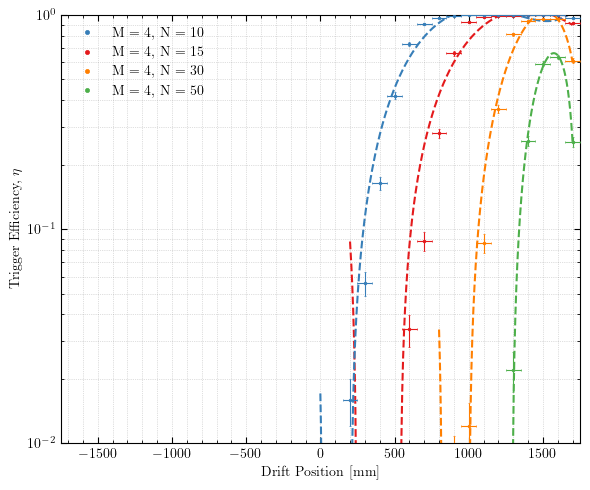

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(6, 5))

unique_combinations = set(zip(m_values, n_values))
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00', '#984EA3', '#A65628', '#F781BF', '#999999']

color_mapping = {}
for i, comb in enumerate(unique_combinations):
    color_mapping[comb] = colors[i % len(colors)]

degree = 4
for comb in unique_combinations:
    x_data = []
    y_data = []

    for i in range(len(drift_distance)):
        if (m_values[i], n_values[i]) == comb:
            efficiency = efficiencies[i]
            if efficiency > 0.002:
                x_data.append(drift_distance[i])
                y_data.append(efficiencies[i])
                
                # Plotting the error bars here
                color = color_mapping[comb]
                ax.errorbar(drift_distance[i], efficiencies[i], yerr=efficiency_errors[i], xerr=100/2.0,
                            marker="o", markeredgewidth=0.5, capsize=1.0, markerfacecolor=color,
                            markeredgecolor=color, ms=2, color=color, lw=0.0, elinewidth=0.8,
                            zorder=10)

    if len(x_data) > degree:  # Ensuring enough data points for the polynomial fit
        coefficients = np.polyfit(x_data, y_data, degree)
        polynomial = np.poly1d(coefficients)
        x_range = np.linspace(min(x_data), max(x_data), 500)
        y_values = polynomial(x_range)
        ax.plot(x_range, y_values, '--', color=color, label=f"Fit for M = {comb[0]}, N = {comb[1]}")

sorted_combinations = sorted(unique_combinations, key=lambda comb: comb[1])

handles = []
for comb in sorted_combinations:
    color = color_mapping[comb]
    line = ax.errorbar([], [], yerr=0.1, fmt='o', color=color, 
                       markeredgewidth=0.5, capsize=1.0, markerfacecolor=color,
                       markeredgecolor=color, ms=3, lw=0.0, elinewidth=0)
    handles.append(line)

legend = ax.legend(handles=handles, labels=[f'M = {comb[0]}, N = {comb[1]}' for comb in sorted_combinations], loc='upper left', fontsize=10, frameon=False)

ax.set_xlabel(r"Drift Position [mm]")
ax.set_ylabel(r"Trigger Efficiency, $\eta$")

ax.set_ylim(1e-2, 1)
ax.set_xlim(-1750, 1750)

ax.tick_params(which='both', direction='in', top=True, right=True, length=4)
ax.tick_params(which='minor', length=2)
ax.minorticks_on()

ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)
ax.set_yscale('log')

plt.tight_layout()
plt.show()
